In [ ]:
# Load necessary libraries
if (!requireNamespace("readxl", quietly = TRUE)) install.packages("readxl")
if (!requireNamespace("googlesheets4", quietly = TRUE)) install.packages("googlesheets4") # nolint: line_length_linter.

library(readxl)
library(googlesheets4)


In [7]:
# Define input and output paths
input_path <- "https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0" # nolint
output_path <- "https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0" # nolint

local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR.csv" # nolint

regression_df <- read.csv(local_input_path)
print(regression_df)


          date       regiao mental_health_visits total_visits periodo
1   2024-12-01          sul               169359      5537357     108
2   2022-07-01          sul               147159      5670166      79
3   2022-11-01          sul               160759      6053194      83
4   2022-10-01          sul               165405      5938846      82
5   2022-09-01          sul               168925      5776479      81
6   2018-04-01          sul                97726      3954977      28
7   2018-05-01          sul                94476      3950949      29
8   2018-06-01          sul                88737      3629643      30
9   2022-08-01          sul               177835      6446181      80
10  2022-06-01          sul               140293      5884884      78
11  2022-02-01          sul               112740      4736730      74
12  2018-07-01          sul                94076      3895748      31
13  2018-08-01          sul               102565      4238054      32
14  2018-09-01      

# Imports

In [ ]:
install.packages(c("glmmTMB", "lme4", "performance", "DHARMa", "ggplot2", "ggeffects", "purrr", "emmeans", "performance", "dplyr", "patchwork", "see", "broom.mixed", "dotwhisker", "MASS", "lme4"))
library(glmmTMB) # For NB GLMM with autocorrelation
library(lme4) # Alternative for basic GLMM
library(performance) # For model checks
library(DHARMa) # For residual diagnostics
library(ggplot2) # For plots
library(ggeffects)
library(purrr)
library(emmeans)
library(performance)
library(dplyr)
library(patchwork)
library(see)
library(broom.mixed)
library(dotwhisker)
library(MASS)
library(lme4)


Warning message:
"os pacotes 'glmmTMB', 'lme4', 'performance', 'DHARMa', 'ggplot2', 'ggeffects', 'purrr', 'emmeans', 'performance', 'dplyr', 'patchwork', 'see', 'broom.mixed', 'dotwhisker', 'MASS', 'lme4' estão em uso e não serão instalados"


# Model Run

In [172]:
# Encontrar o primeiro período onde Pandemia_Step == 1
pandemic_start_info <- regression_df %>%
  filter(Pandemia_Step == 1) %>%
  arrange(periodo) %>%
  slice(1) # Pega a primeira ocorrência

pandemic_start_date <- pandemic_start_info$periodo
print(pandemic_start_date)

DUMMIES_LIST <- c("Pandemia_Step", "Pandemia_Trend", "PosPandemia_Step", "PosPandemia_Trend")

REGIOES_LIST <- unique(regression_df$regiao)
REGIOES_LIST


[1] 52


[1] "sul"          "sudeste"      "norte"        "nordeste"     "centro_oeste"

In [ ]:
# First ensure your time variable is a factor
regression_df$periodo_fac <- as.factor(regression_df$periodo)


# First, run the model with a consistent name

model <- glmer(
  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +
    PosPandemia_Step + PosPandemia_Trend + offset(log(total_visits / 1000)) +
    (1 + periodo + Pandemia_Step + Pandemia_Trend | regiao),
  family = poisson(link = "log"),
  data = regression_df,
  control = glmerControl(optimizer = "bobyqa") # Often helps with convergence
)

# Model summary interpretation
summary(model)

# Key components to check:
# - Fixed effects (global trends)
# - Random effects variance (region differences)
# - AR1 parameter (temporal autocorrelation)


Warning message in optwrap(optimizer, devfun, start, rho$lower, control = control, :
"convergence code 1 from bobyqa: bobyqa -- maximum number of function evaluations exceeded"
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"unable to evaluate scaled gradient"
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge: degenerate  Hessian with 2 negative eigenvalues"


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +  
    PosPandemia_Step + PosPandemia_Trend + offset(log(total_visits/1000)) +  
    (1 + periodo + Pandemia_Step + Pandemia_Trend | regiao)
   Data: regression_df
Control: glmerControl(optimizer = "bobyqa")

      AIC       BIC    logLik -2*log(L)  df.resid 
 268344.7  268413.4 -134156.3  268312.7       524 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-124.199  -12.754    1.458   13.916   55.944 

Random effects:
 Groups Name           Variance  Std.Dev. Corr             
 regiao (Intercept)    2.191e-01 0.468114                  
        periodo        1.932e-05 0.004396 -0.96            
        Pandemia_Step  4.731e-02 0.217512  0.24 -0.24      
        Pandemia_Trend 1.495e-03 0.038663  0.15 -0.28  0.90
Number of obs: 540, groups:  regiao, 5

Fixed effects:
           

# Region Models

In [152]:
region_models <- regression_df %>%
  group_by(regiao) %>%
  group_map(~ tidy(
    glm(
      mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +
        PosPandemia_Step + PosPandemia_Trend +
        offset(log(total_visits / 1000)),
      family = poisson(),
      data = .x
    )
  ))

# Combine results
region_results <- region_models %>%
  setNames(unique(regression_df$regiao)) %>%
  bind_rows(.id = "regiao")

region_results


regiao,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
sul,(Intercept),2.4206607529,2.609000e-03,927.811678,0.000000e+00
sul,periodo,0.0171790027,7.391001e-05,232.431337,0.000000e+00
sul,Pandemia_Step,-0.0192754213,2.851107e-03,-6.760679,1.373464e-11
sul,Pandemia_Trend,-0.0200123584,1.698630e-04,-117.814727,0.000000e+00
sul,PosPandemia_Step,-0.4201065270,3.592645e-03,-116.935175,0.000000e+00
sul,PosPandemia_Trend,-0.0135612344,1.033802e-04,-131.178310,0.000000e+00
sudeste,(Intercept),1.7198314205,1.713428e-03,1003.737226,0.000000e+00
sudeste,periodo,0.0193766116,4.966150e-05,390.173713,0.000000e+00
sudeste,Pandemia_Step,0.2466914706,1.886306e-03,130.780206,0.000000e+00


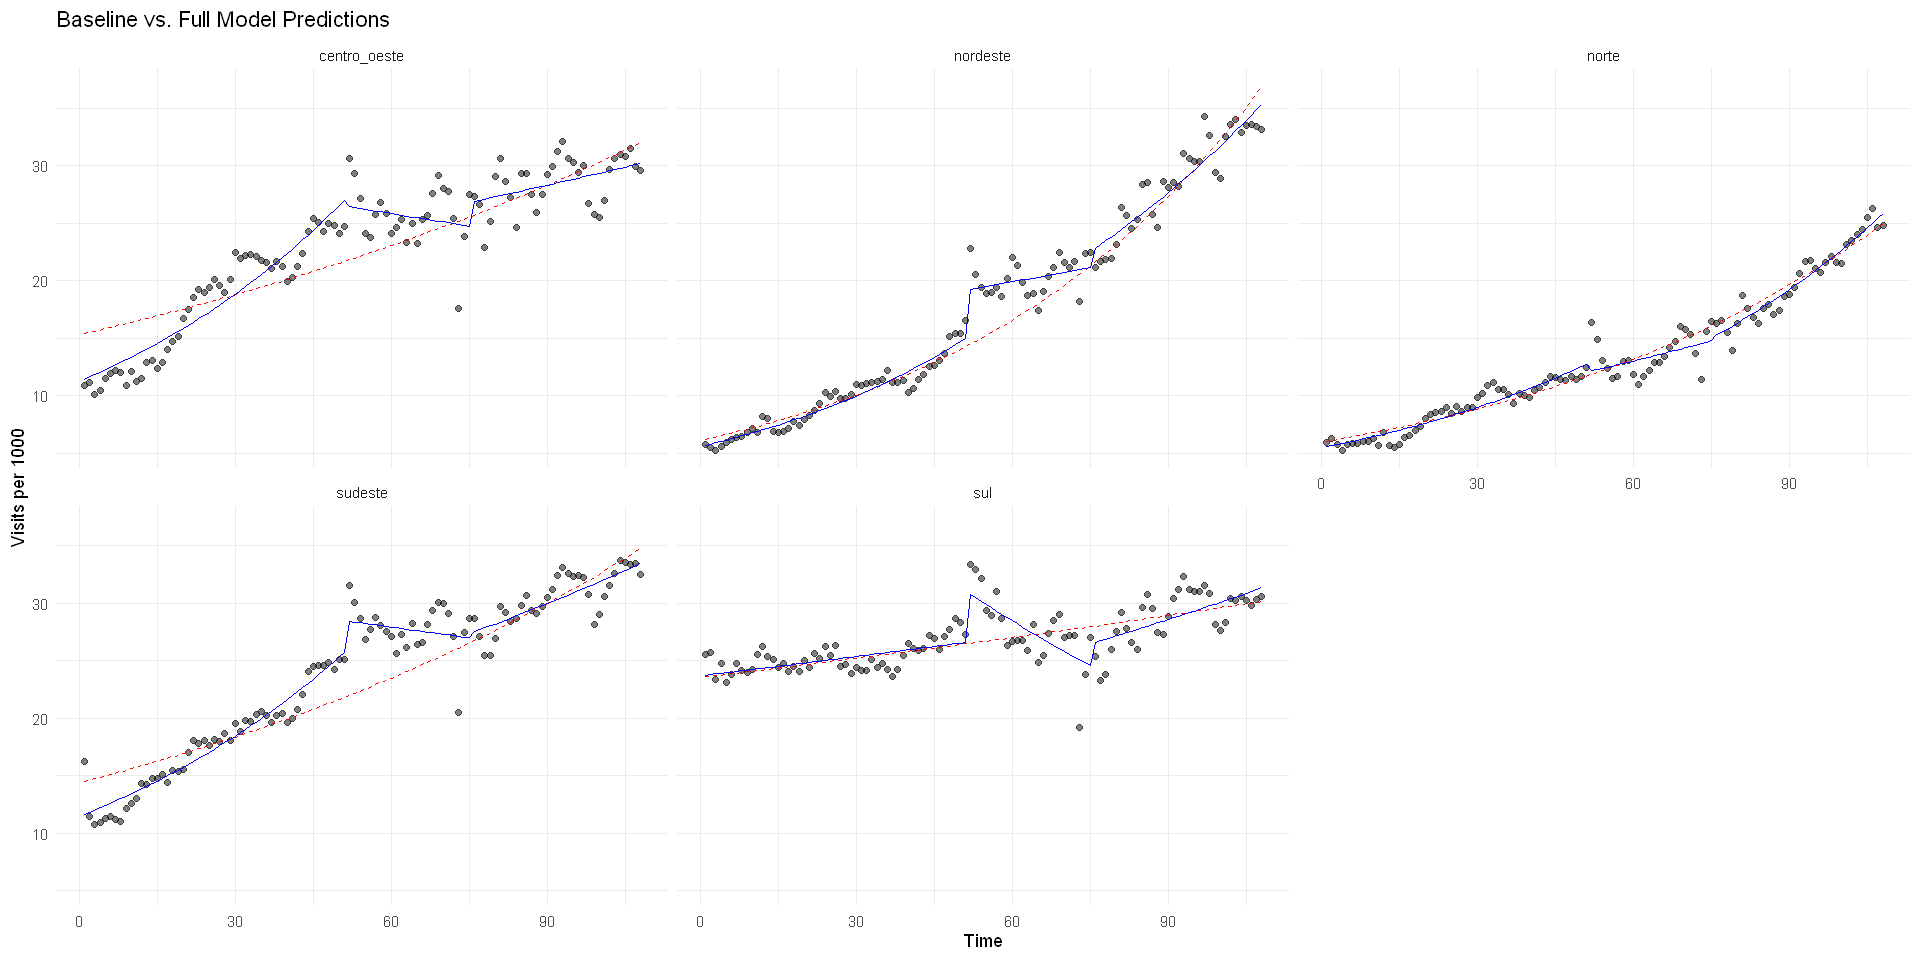

In [167]:
library(dplyr)
library(purrr)
library(ggplot2)

# 1. First, create a function that calculates predictions for one region
get_predictions <- function(region_data) {
  # Fit baseline model (pre-pandemic only)
  baseline_model <- glm(
    mental_health_visits ~ periodo,
    family = poisson(),
    data = filter(region_data, Pandemia_Step == 0),
    offset = log(total_visits / 1000)
  )

  # Fit full model
  full_model <- glm(
    mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +
      PosPandemia_Step + PosPandemia_Trend,
    family = poisson(),
    data = region_data,
    offset = log(total_visits / 1000)
  )

  # Add predictions
  region_data %>%
    mutate(
      baseline_pred = predict(baseline_model, newdata = ., type = "response"),
      full_pred = predict(full_model, type = "response"),
      rate_observed = mental_health_visits / (total_visits / 1000),
      rate_baseline = baseline_pred / (total_visits / 1000),
      rate_full = full_pred / (total_visits / 1000)
    )
}

# 2. Apply to all regions
plot_data <- regression_df %>%
  group_by(regiao) %>%
  group_modify(~ get_predictions(.x)) %>%
  ungroup()

# 3. Plot the results
ggplot(plot_data, aes(x = periodo)) +
  geom_point(aes(y = rate_observed), alpha = 0.5) +
  geom_line(aes(y = rate_baseline), color = "#ff0000", linetype = "dashed") +
  geom_line(aes(y = rate_full), color = "blue") +
  facet_wrap(~regiao) +
  labs(
    title = "Baseline vs. Full Model Predictions",
    y = "Visits per 1000",
    x = "Time"
  ) +
  theme_minimal()


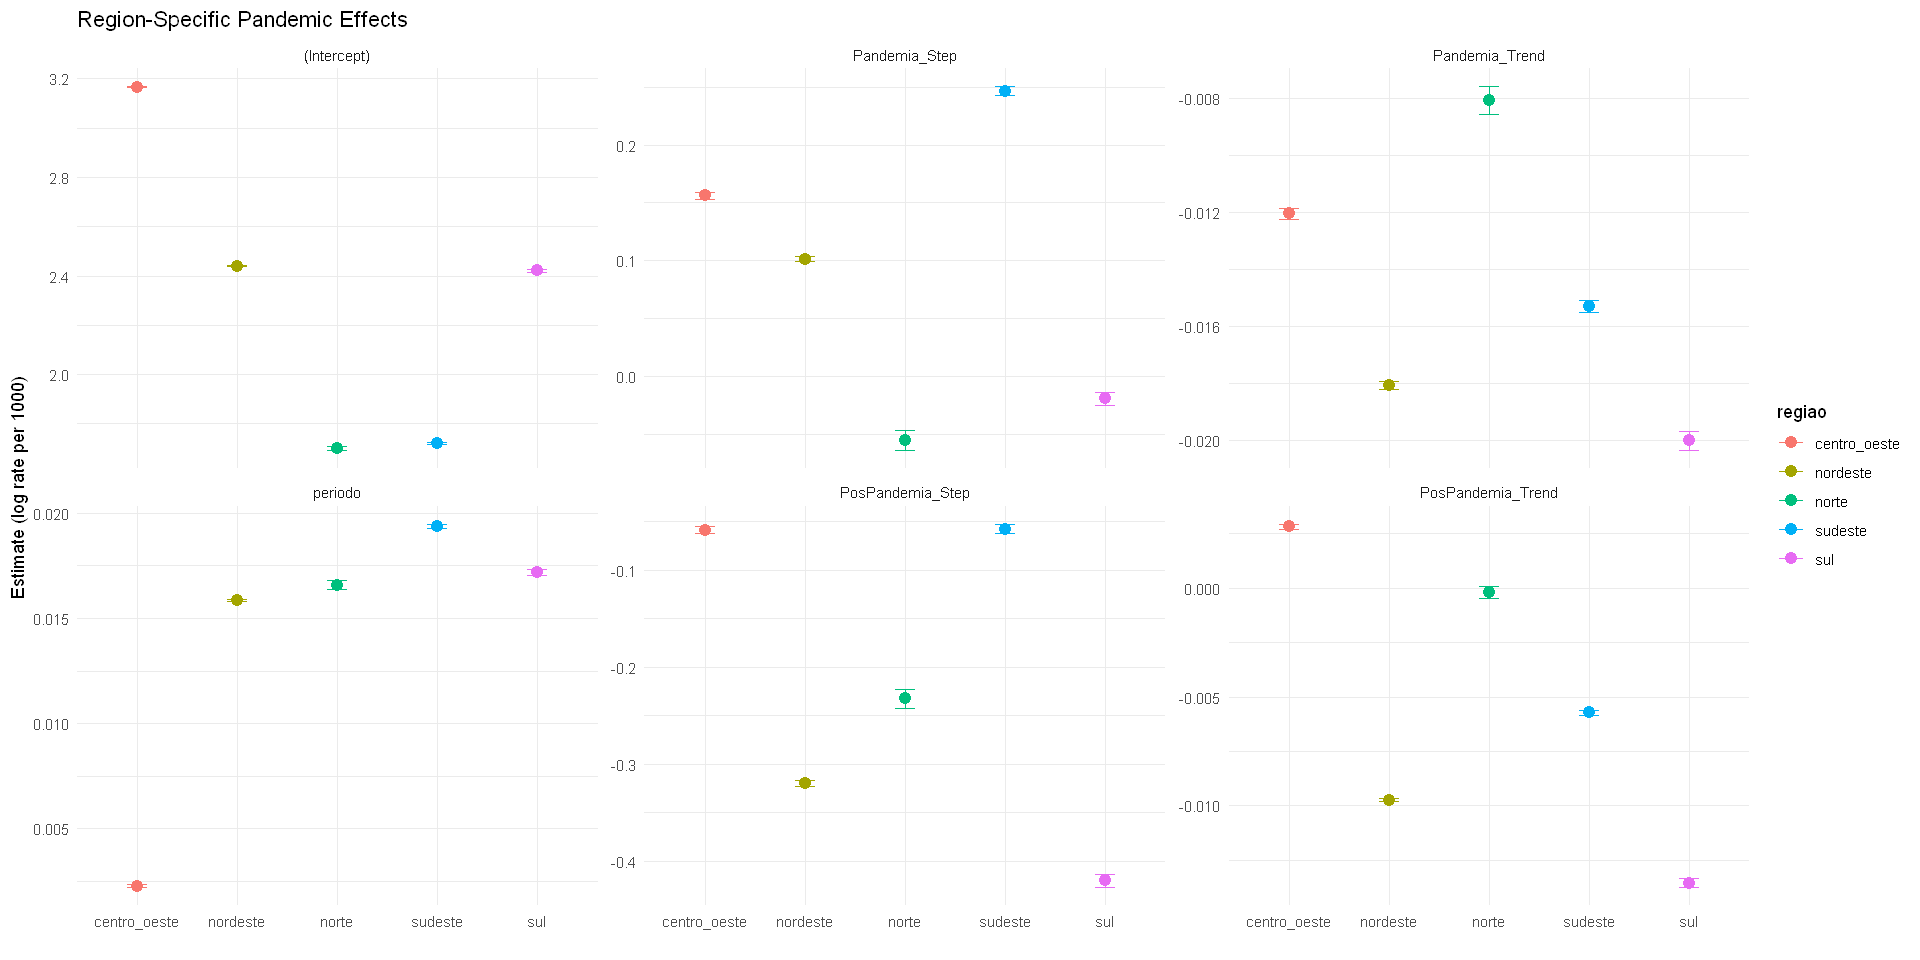

In [177]:
ggplot(region_results, aes(x = regiao, y = estimate, color = regiao)) +
     geom_point(size = 3) +
     geom_errorbar(
          aes(
               ymin = estimate - 1.96 * std.error,
               ymax = estimate + 1.96 * std.error
          ),
          width = 0.2
     ) +
     facet_wrap(~term, scales = "free_y") +
     labs(
          title = "Region-Specific Pandemic Effects",
          y = "Estimate (log rate per 1000)", x = ""
     ) +
     theme_minimal()


# Diagnostics

In [178]:
diagnose(model)


ERROR: Error in fit$obj: $ operator not defined for this S4 class


In [179]:
# Check convergence
summary(model)$convergence # Should be TRUE

# Inspect random effects
ranef(model)$cond$regiao %>% head()

# Check for singularity
performance::check_singularity(model)


NULL

NULL

[1] FALSE

Model uses a transformed offset term. Predictions may not be correct.
  It is recommended to fix the offset term using the `condition` argument,
  e.g. `condition = c(total_visits = 1)`.
  You could also transform the offset variable before fitting the model
  and use `offset(total_visits)` in the model formula.



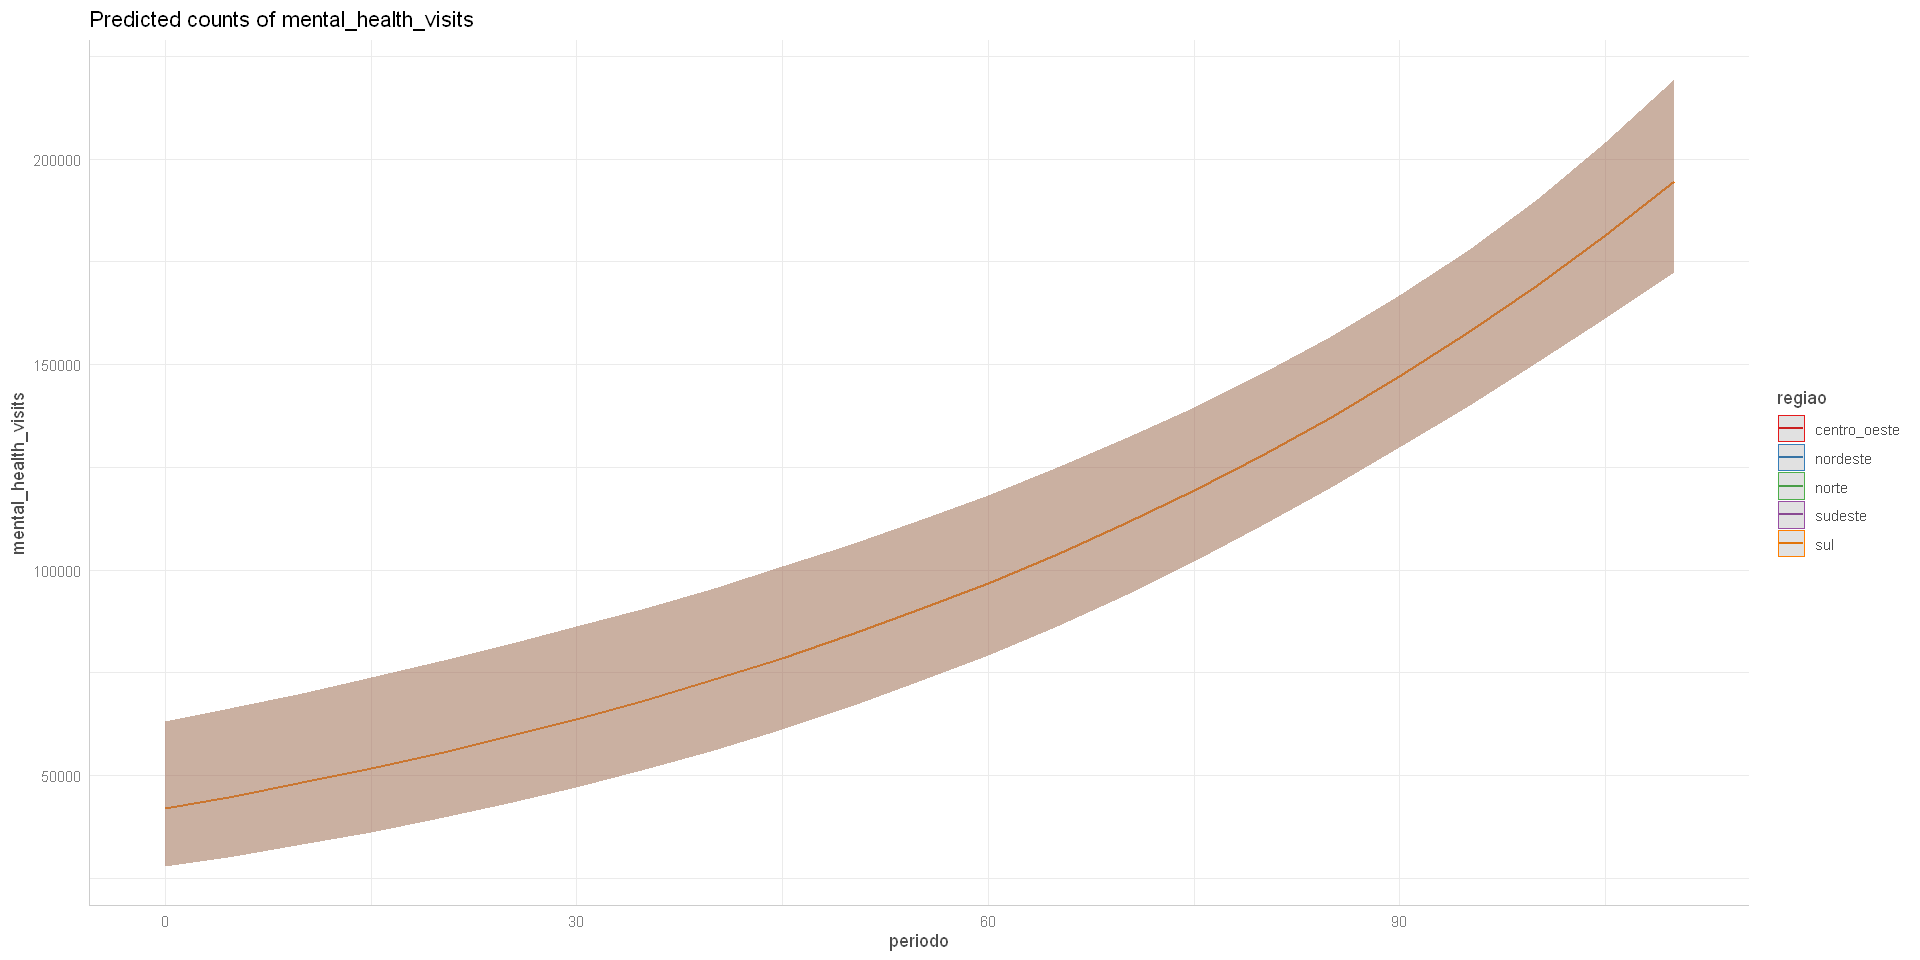

In [180]:
plot(ggpredict(model, terms = c("periodo", "regiao")))


In [181]:
# Check convergence (should be TRUE)
model$fit$convergence == 0

# View optimization details
model$fit$message


ERROR: Error in model$fit: $ operator not defined for this S4 class


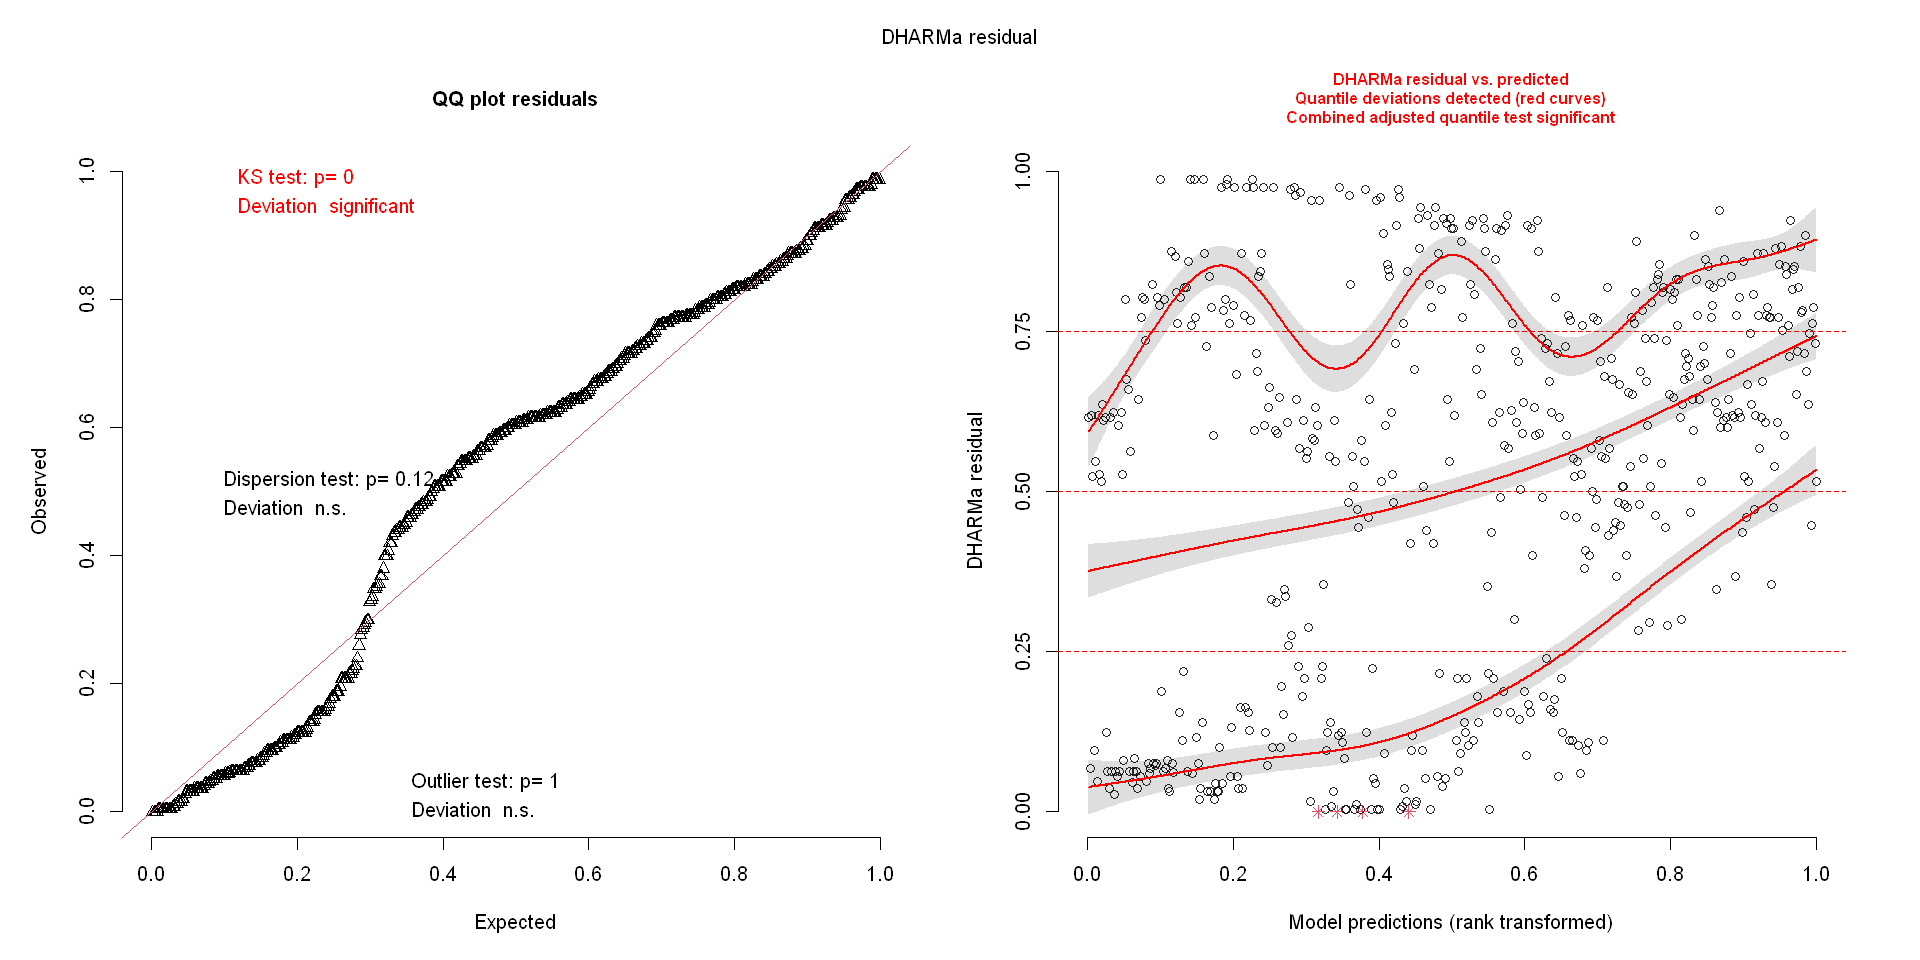

In [182]:
# Residuals Diagnostics
sim_res <- simulateResiduals(model, plot = TRUE)


In [183]:
# 3. Random Effects Distribution

# 1. Extrair efeitos aleatórios corretamente
ranefs <- ranef(model)$cond$regiao

# 2. Converter para dataframe para facilitar o plot
ranef_df <- data.frame(
  Region = rownames(ranefs),
  Intercept = ranefs[, 1]
)

# 3. Plot dos interceptos aleatórios
plot_intercepts <- ggplot(ranef_df, aes(x = Region, y = Intercept)) +
  geom_col(fill = "skyblue", alpha = 0.8) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(
    title = "Variação dos Interceptos por Região",
    subtitle = "Desvios em relação à média global",
    y = "Intercepto Aleatório",
    x = "Região"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(plot_intercepts)

# 4. Verificar e plotar slopes aleatórios (se existirem)
if ("periodo" %in% colnames(ranefs)) {
  ranef_df$Slope <- ranefs[, "periodo"]

  plot_slopes <- ggplot(ranef_df, aes(x = Region, y = Slope)) +
    geom_col(fill = "salmon", alpha = 0.8) +
    geom_hline(yintercept = 0, linetype = "dashed") +
    labs(
      title = "Variação das Tendências Temporais por Região",
      subtitle = "Desvios na inclinação do período",
      y = "Slope Aleatório",
      x = "Região"
    ) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

  print(plot_slopes)
} else {
  message("O modelo não inclui slopes aleatórios para 'periodo'")
}


ERROR: [1m[33mError[39m in `geom_col()`:[22m
[1m[22m[33m![39m Problem while computing aesthetics.
[36mℹ[39m Error occurred in the 1st layer.
[1mCaused by error:[22m
[33m![39m objeto 'Region' não encontrado


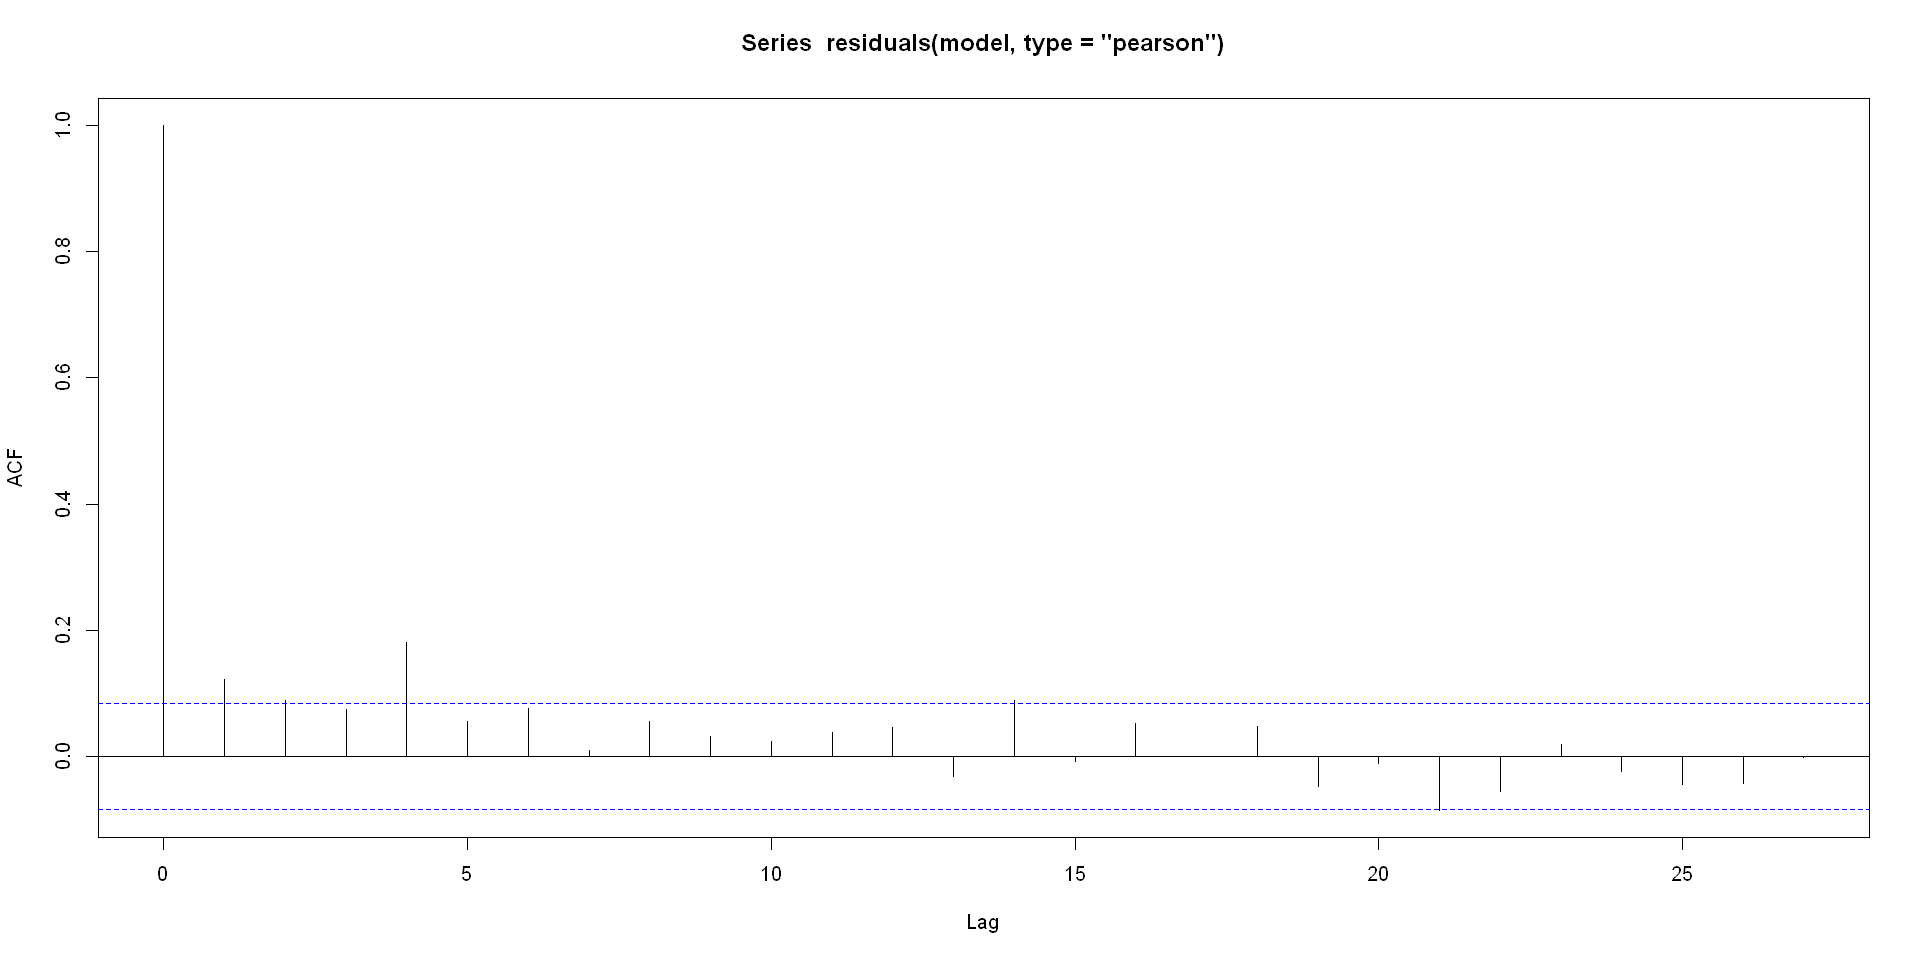

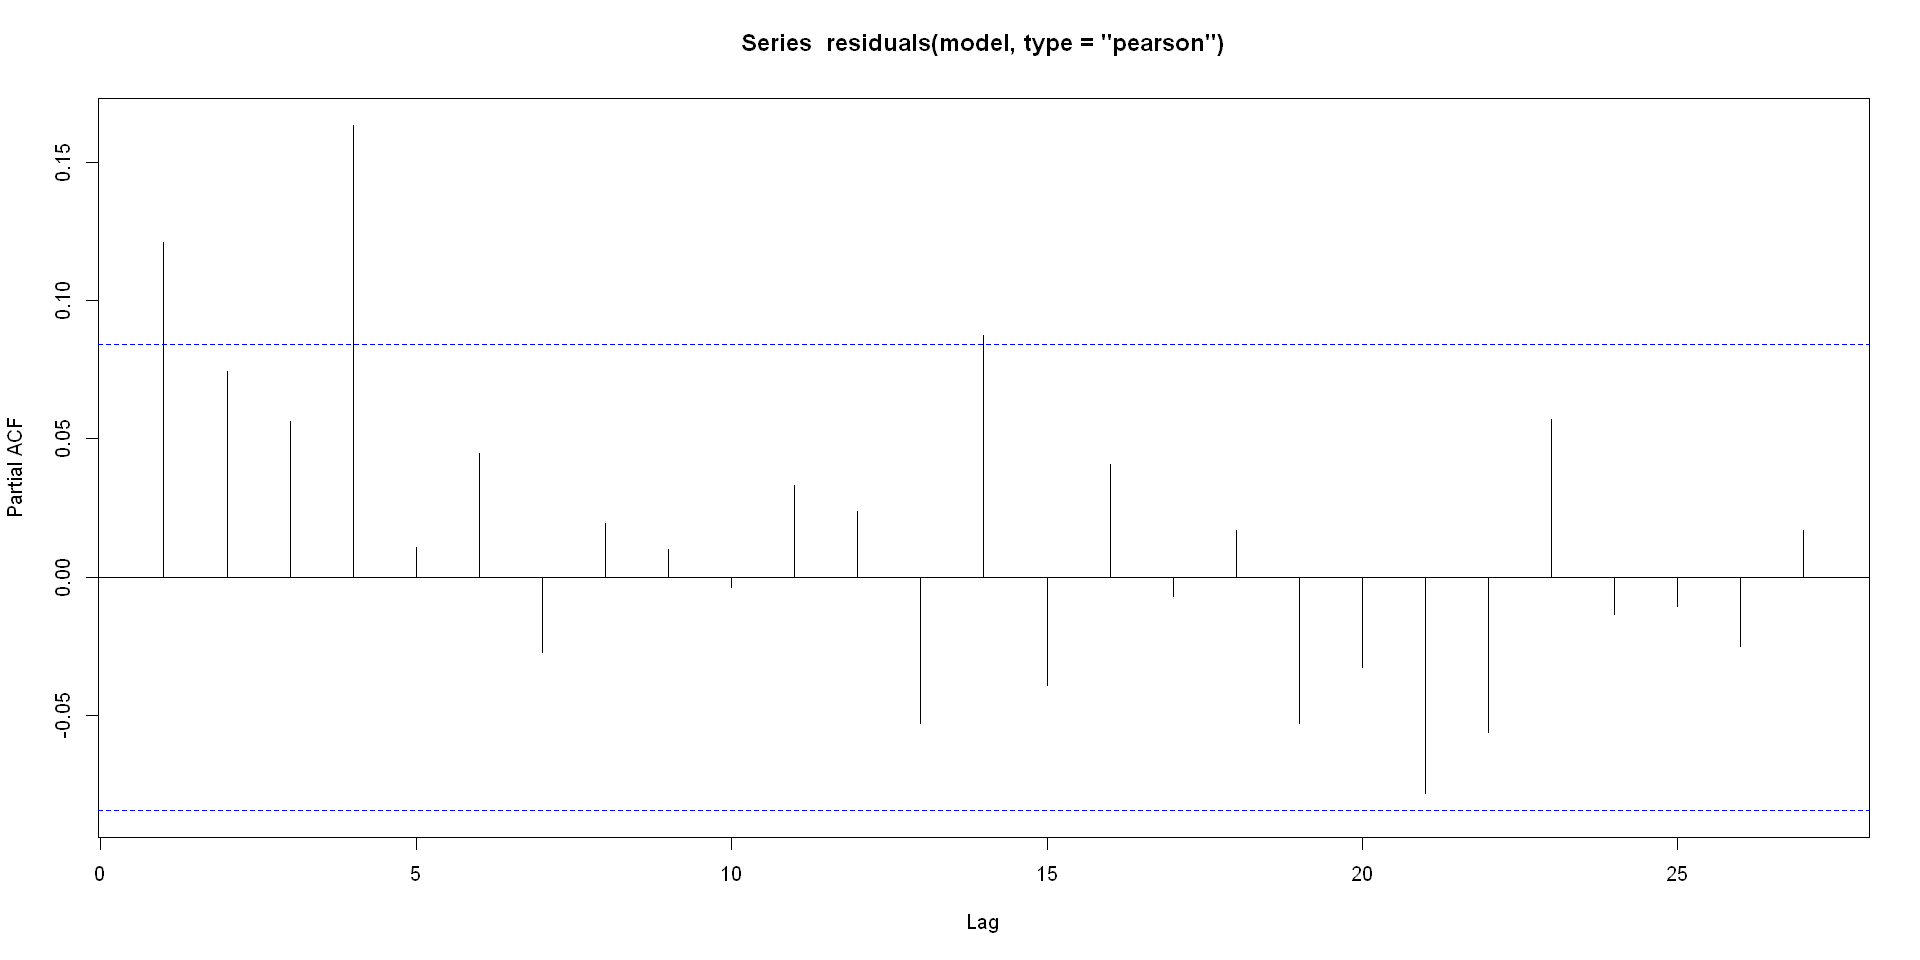

In [184]:
# Plot ACF/PACF of residuals
acf(residuals(model, type = "pearson"))
pacf(residuals(model, type = "pearson"))



	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
dispersion = 0.024714, p-value < 2.2e-16
alternative hypothesis: two.sided


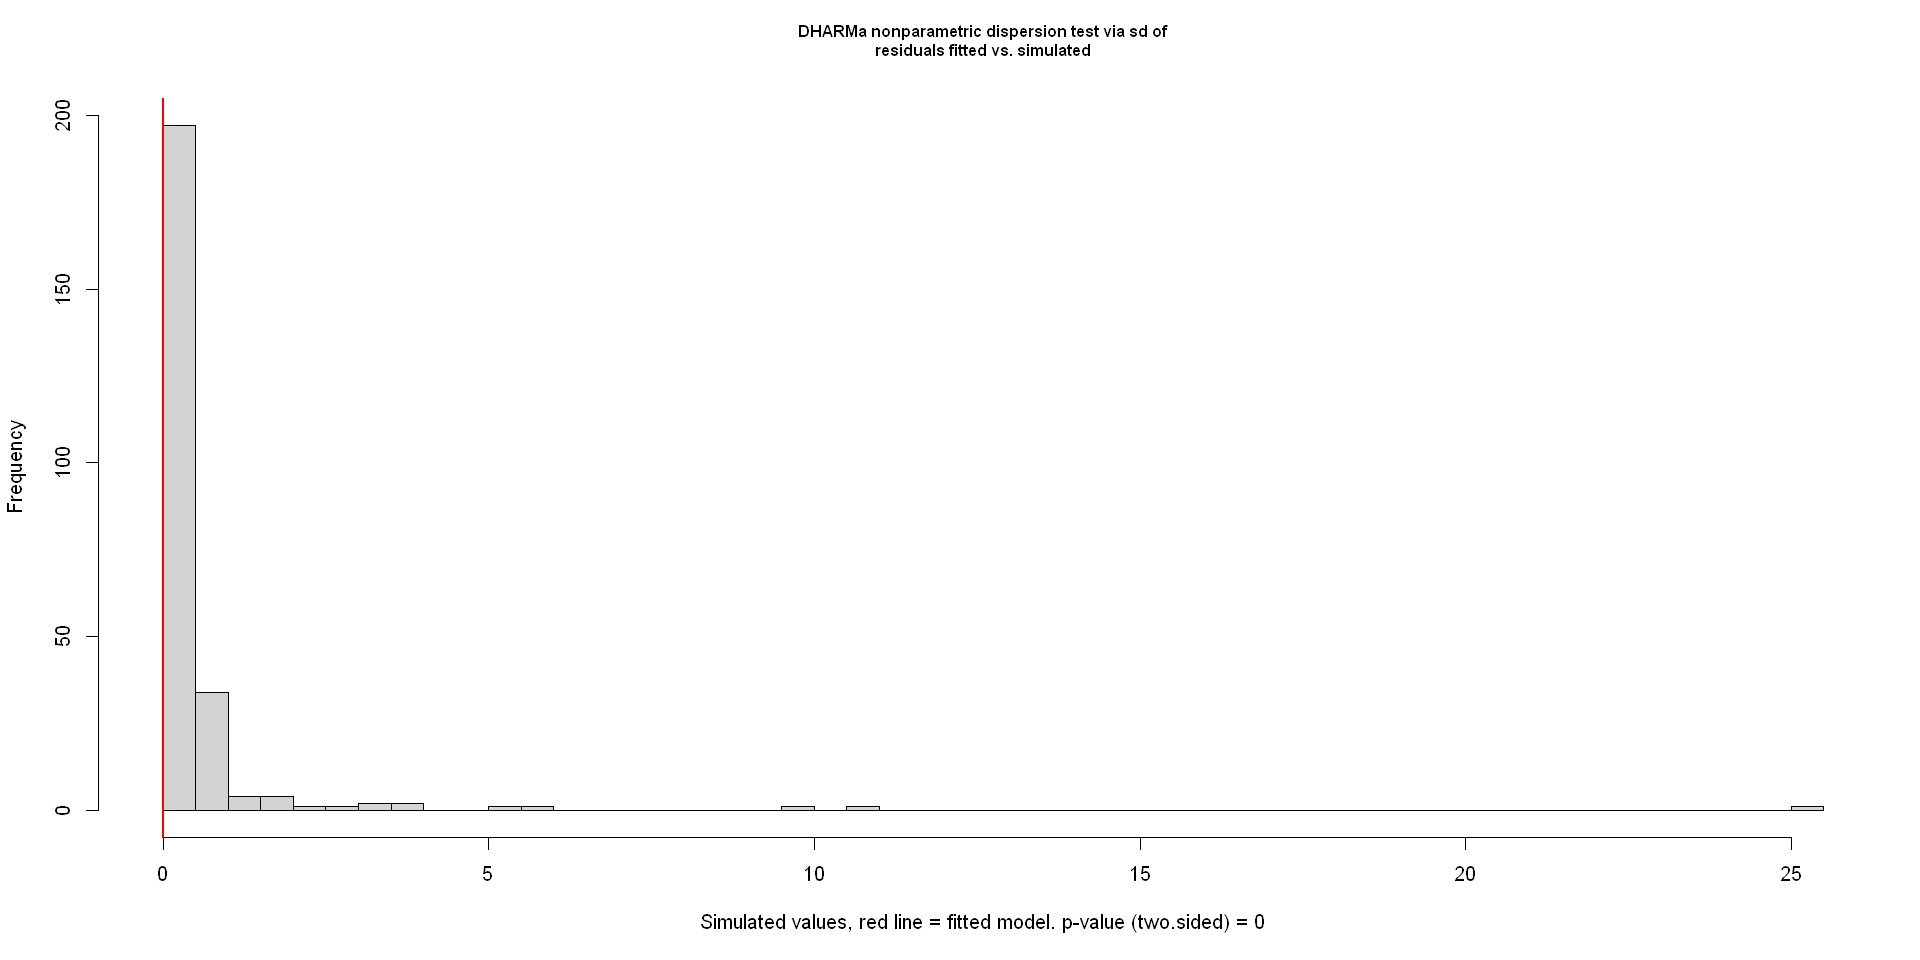

In [107]:
# Overdispersion Test
testDispersion(sim_res)
# Ratio should be close to 1


Some of the focal terms are of type `character`. This may lead to
  unexpected results. It is recommended to convert these variables to
  factors before fitting the model.
  The following variables are of type character: `regiao`

Model uses a transformed offset term. Predictions may not be correct.
  It is recommended to fix the offset term using the `condition` argument,
  e.g. `condition = c(total_visits = 1)`.
  You could also transform the offset variable before fitting the model
  and use `offset(total_visits)` in the model formula.



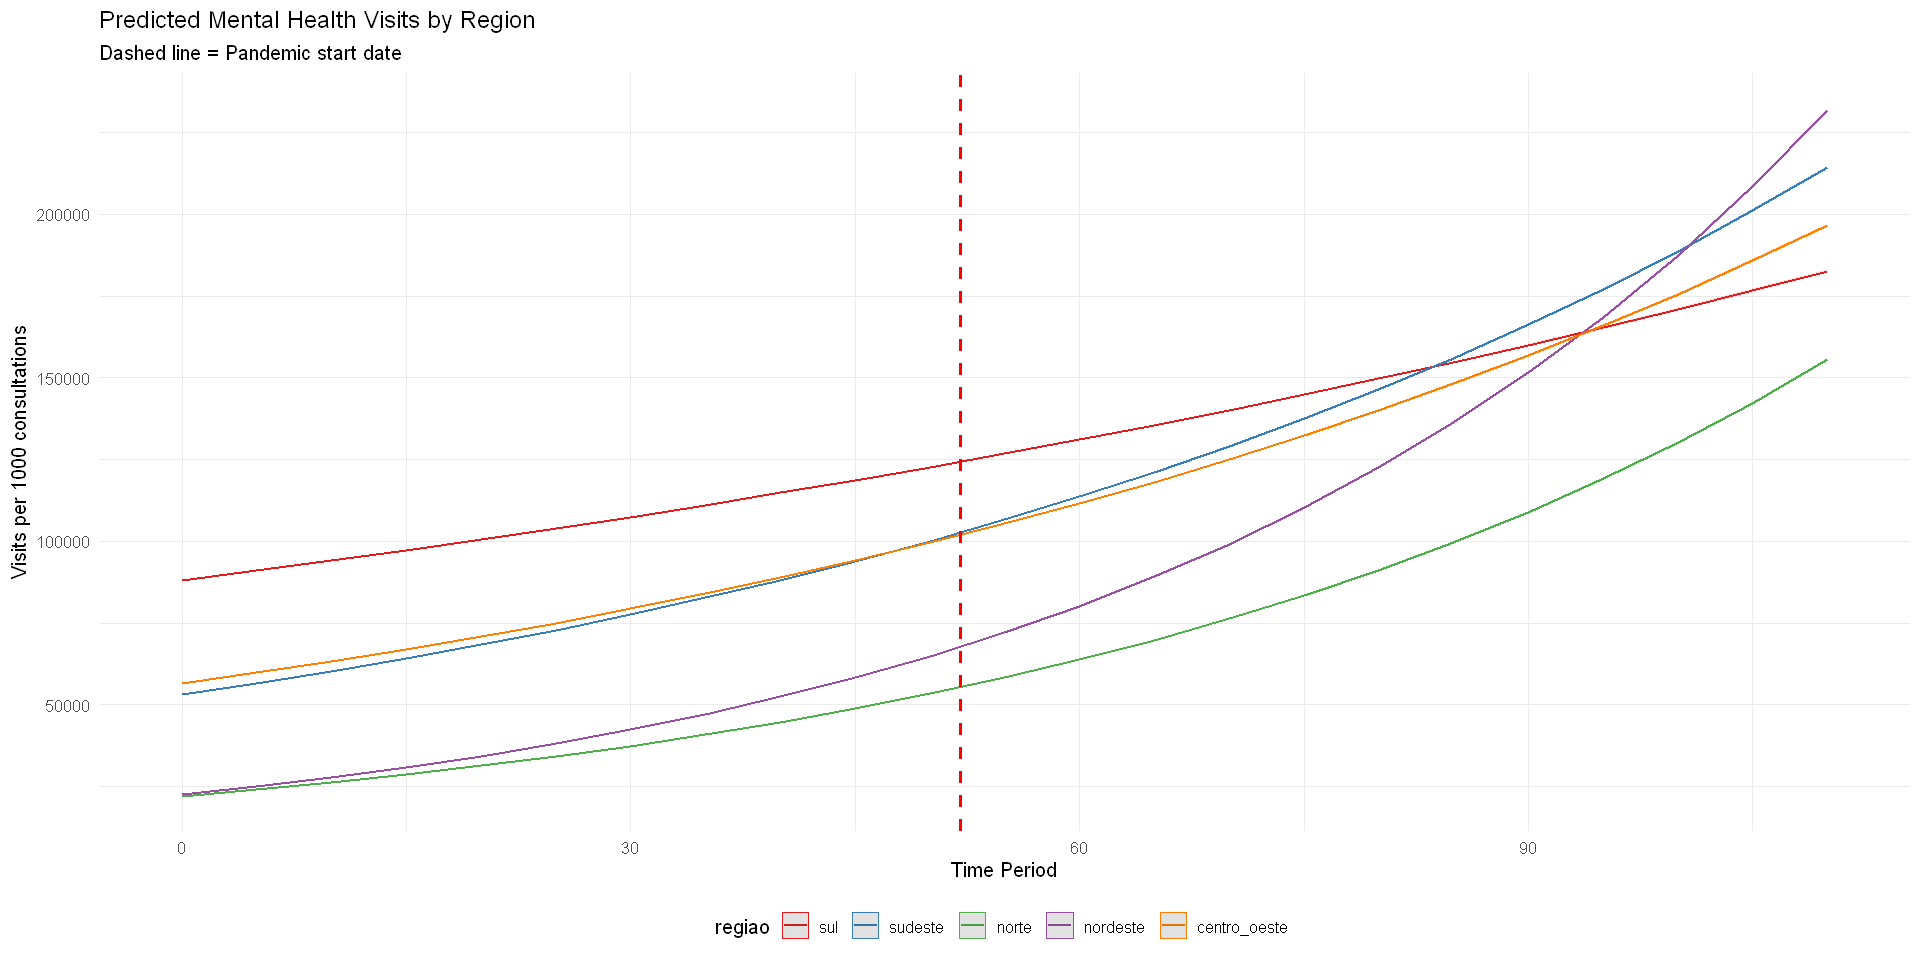

In [127]:
# Fixed Effects Visualization

# Generate predictions
preds <- ggpredict(model,
  terms = c("periodo", "regiao"), # Vary periodo by region
  type = "random"
) # Include random effects

# Plot with pandemic marker
fixed_plot <- plot(preds) +
  geom_vline(
    xintercept = pandemic_start_date,
    linetype = "dashed",
    color = "red",
    linewidth = 1
  ) +
  labs(
    title = "Predicted Mental Health Visits by Region",
    subtitle = "Dashed line = Pandemic start date",
    y = "Visits per 1000 consultations",
    x = "Time Period"
  ) +
  theme_minimal(base_size = 12) +
  theme(legend.position = "bottom")

print(fixed_plot)


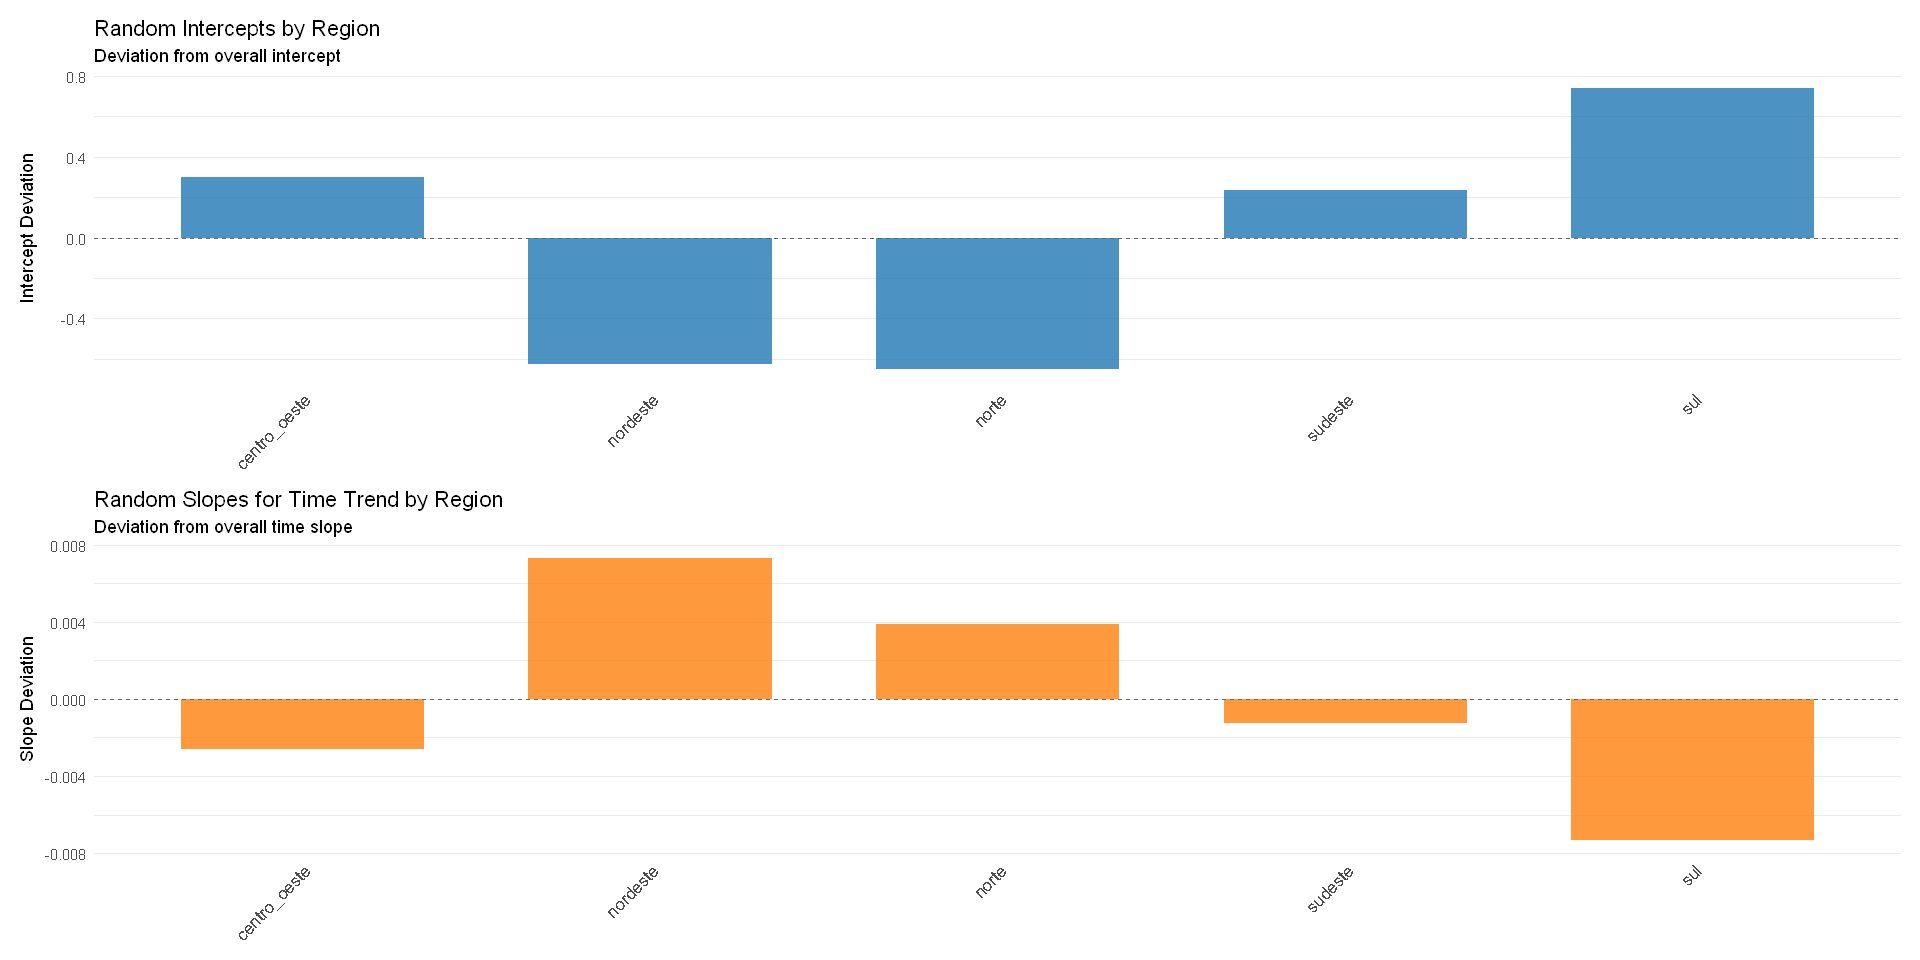

In [128]:
# Extract random effects safely
ranefs <- ranef(model)$cond$regiao

# Convert to dataframe
ranef_df <- as.data.frame(ranefs)
ranef_df$Region <- rownames(ranefs)

# 1. Plot Random Intercepts
intercept_plot <- ggplot(ranef_df, aes(x = Region, y = `(Intercept)`)) +
  geom_col(fill = "#1f77b4", alpha = 0.8, width = 0.7) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "gray40") +
  labs(
    title = "Random Intercepts by Region",
    subtitle = "Deviation from overall intercept",
    y = "Intercept Deviation",
    x = NULL
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    panel.grid.major.x = element_blank()
  )

# 2. Plot Random Slopes (if they exist)
if ("periodo" %in% names(ranef_df)) {
  slope_plot <- ggplot(ranef_df, aes(x = Region, y = periodo)) +
    geom_col(fill = "#ff7f0e", alpha = 0.8, width = 0.7) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "gray40") +
    labs(
      title = "Random Slopes for Time Trend by Region",
      subtitle = "Deviation from overall time slope",
      y = "Slope Deviation",
      x = NULL
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
      panel.grid.major.x = element_blank()
    )

  # Display both plots
  library(patchwork)
  combined_plots <- intercept_plot + slope_plot + plot_layout(ncol = 1)
  print(combined_plots)
} else {
  print(intercept_plot)
  message("\nNote: No random slopes for 'periodo' in the model")
}


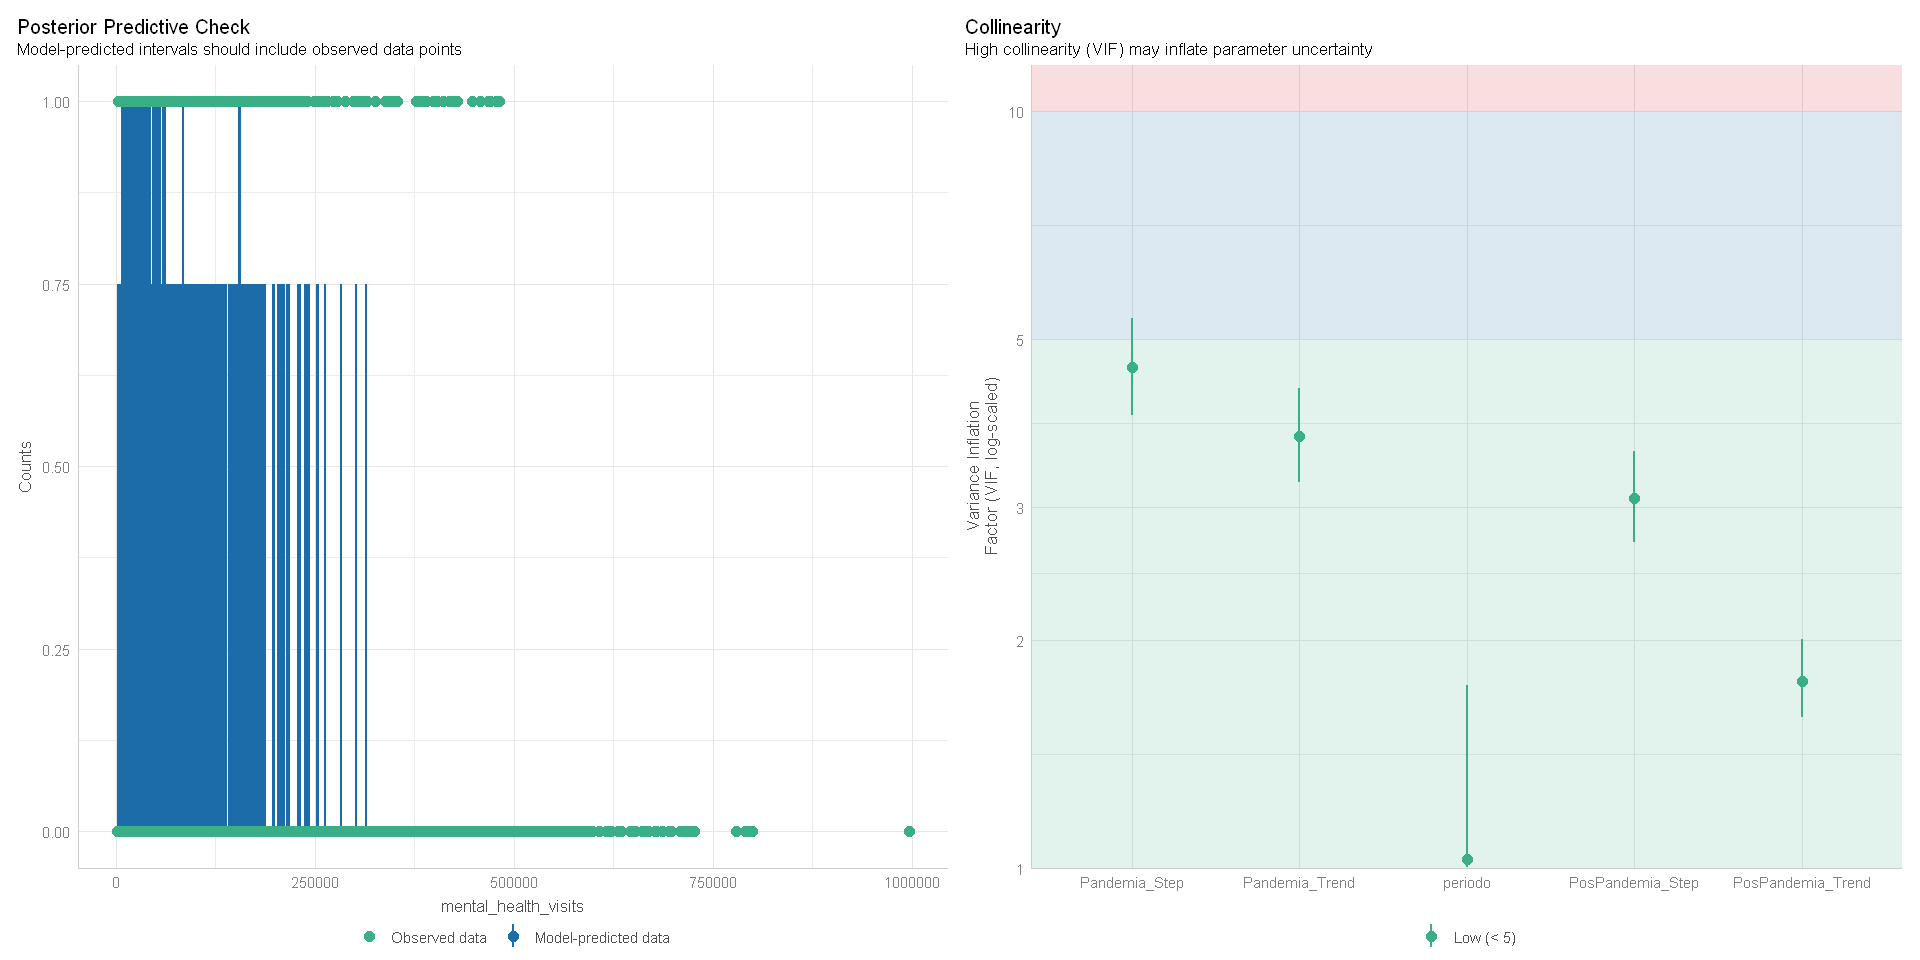

In [81]:
# Influence Diagnostics (aparentemente DHARMa test residuals é mais adequado para este modelo (glmmTMB))
# check_model(model,
#           check = c("vif", "pp_check", "binned_residuals"),
#           residual_type = "normal")  # Critical for glmmTMB


In [110]:
# Effect Sizes
# Get rate ratios for pandemic effect
emmeans(model, ~Pandemia_Step, type = "response")


 Pandemia_Step response       SE  df asymp.LCL asymp.UCL
             0 2.35e+08 64100000 Inf  1.38e+08  4.01e+08
             1 2.58e+08 70900000 Inf  1.51e+08  4.42e+08

Results are averaged over the levels of: PosPandemia_Step 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 

In [129]:
# Check if fixed model is better
# Fit a model WITHOUT random slopes for pandemic
model_fixed <- update(model, . ~ . - (1 + periodo | regiao) + (1 | regiao))

# Likelihood Ratio Test
anova(model, model_fixed)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model,10,268353.4,268396.3,-134166.7,268333.4,NA,NA,NA
model_fixed,10,268353.4,268396.3,-134166.7,268333.4,0,0,1


# Region Coefficients

In [130]:
# Get ALL fixed effects with CIs
all_coefs <- tidy(model,
  conf.int = TRUE,
  effects = "fixed"
) %>% # Extract fixed effects only
  mutate( # Exponentiate if using log/logit link
    estimate = exp(estimate), # Remove if not needed
    conf.low = exp(conf.low),
    conf.high = exp(conf.high)
  )

# Filter for regions and pandemic dummies
key_coefs <- all_coefs %>%
  filter(grepl("regiao", term, ignore.case = TRUE) |
    grepl(paste(DUMMIES_LIST, collapse = "|"), term, ignore.case = TRUE))

print(key_coefs, n = Inf) # Show all rows


# A tibble: 4 × 9
  effect component term           estimate std.error statistic  p.value conf.low
  <chr>  <chr>     <chr>             <dbl>     <dbl>     <dbl>    <dbl>    <dbl>
1 fixed  cond      Pandemia_Step     1.10  0.0419         2.18 2.94e- 2    1.01 
2 fixed  cond      Pandemia_Trend    0.986 0.00122      -11.8  5.58e-32    0.983
3 fixed  cond      PosPandemia_S…    0.824 0.00100     -193.   0           0.823
4 fixed  cond      PosPandemia_T…    0.994 0.0000283   -196.   0           0.994
# ℹ 1 more variable: conf.high <dbl>


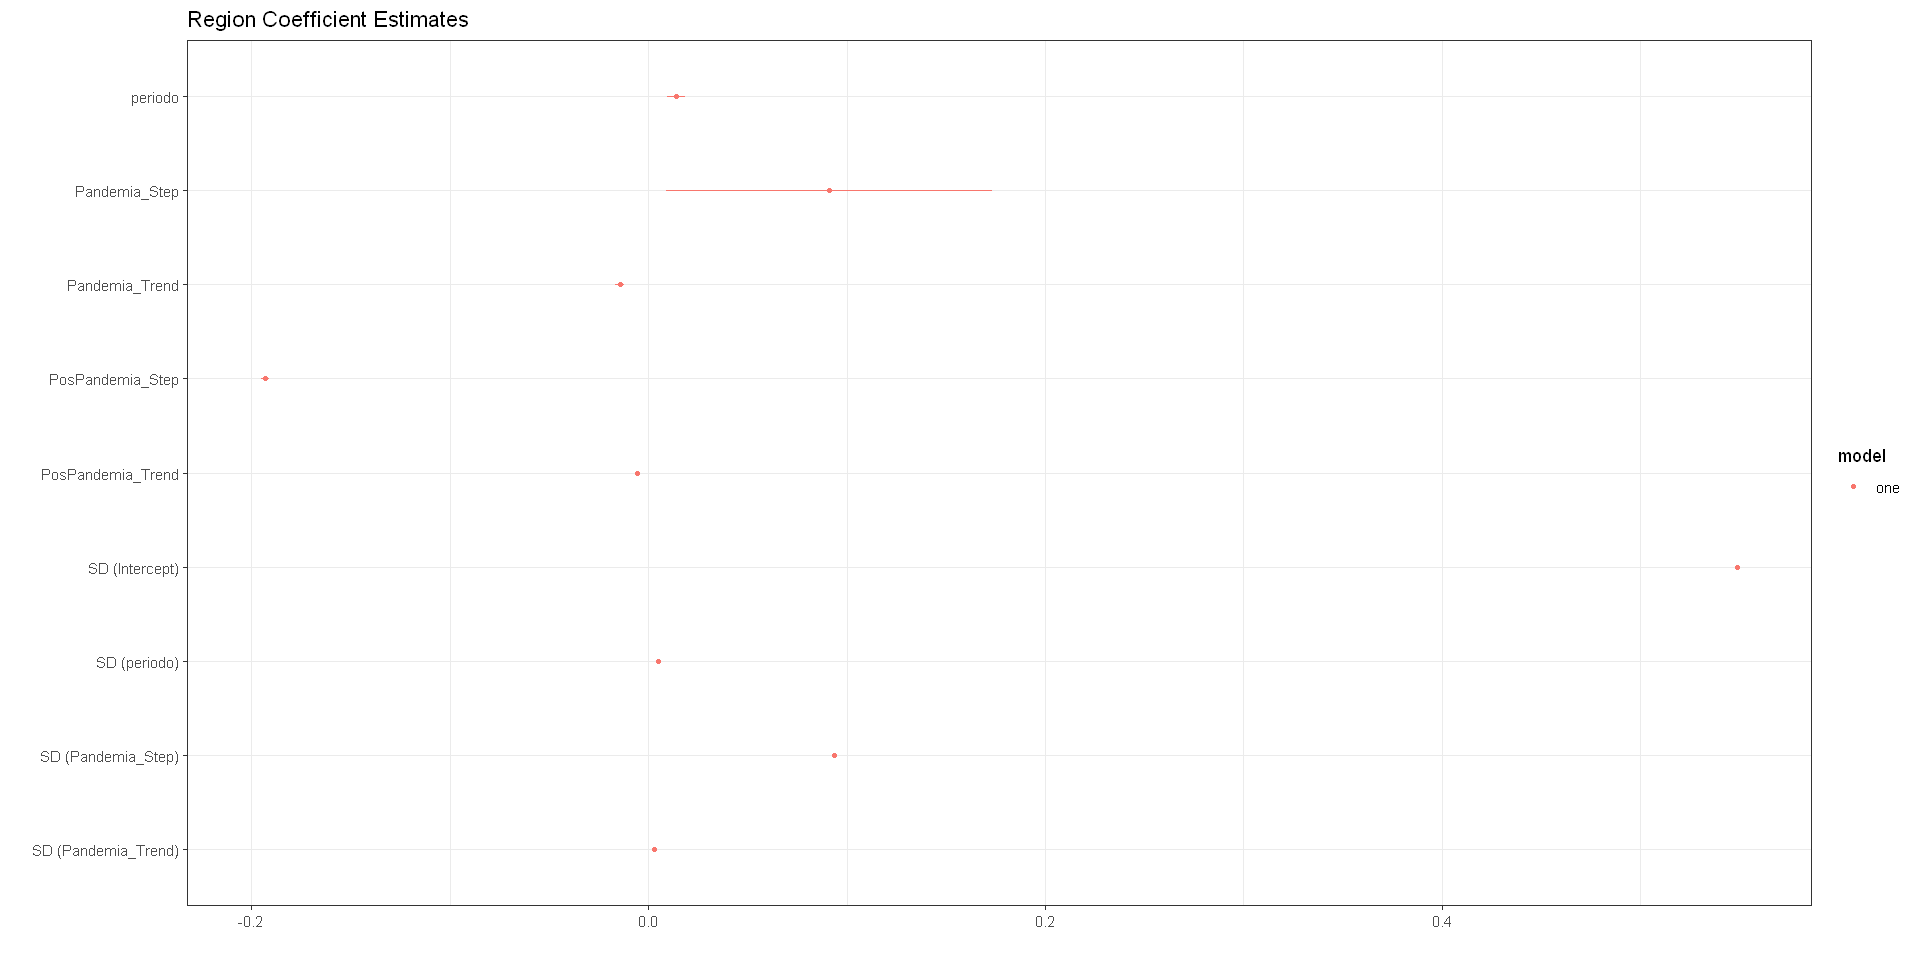

In [131]:
dwplot(model, show_intercept = FALSE) +
  theme_bw() +
  ggtitle("Region Coefficient Estimates")


In [133]:
# Get fixed effects with confidence intervals
# Get fixed effects
coef_table <- tidy(model, conf.int = TRUE, effects = "fixed")


# Filter for terms that exactly match REGIOES_LIST
region_coefs <- coef_table %>%
  filter(term %in% REGIOES_LIST) # Exact matching

# Print results
print(region_coefs)


# A tibble: 0 × 9
# ℹ 9 variables: effect <chr>, component <chr>, term <chr>, estimate <dbl>,
#   std.error <dbl>, statistic <dbl>, p.value <dbl>, conf.low <dbl>,
#   conf.high <dbl>


In [134]:
# Get Random Effects
ranef(model)$cond$regiao # For conditional model (adjust if using zero-inflation)


,(Intercept),periodo,Pandemia_Step,Pandemia_Trend
,<dbl>,<dbl>,<dbl>,<dbl>
centro_oeste,0.2979733,-0.002604056,0.01016291,0.0002293900
nordeste,-0.6254816,0.007285852,0.10637063,-0.0027374576
norte,-0.6494205,0.003877494,-0.15953819,0.0050358049
sudeste,0.2351029,-0.001253439,0.07654239,-0.0005156312
sul,0.7413790,-0.007305743,-0.03355314,-0.0020121585


# other stuff


In [135]:
preds <- ggpredict(model, terms = c("periodo", "regiao"))
# plot(preds) # Plot trends by region


Some of the focal terms are of type `character`. This may lead to
  unexpected results. It is recommended to convert these variables to
  factors before fitting the model.
  The following variables are of type character: `regiao`

Model uses a transformed offset term. Predictions may not be correct.
  It is recommended to fix the offset term using the `condition` argument,
  e.g. `condition = c(total_visits = 1)`.
  You could also transform the offset variable before fitting the model
  and use `offset(total_visits)` in the model formula.



In [136]:
# Get region-specific intercepts and slopes
region_intercepts <- fixef(model)$cond[1] + ranef(model)$cond$regiao[, 1]
region_slopes <- fixef(model)$cond[2] + ranef(model)$cond$regiao[, 2]

# Calculate region-specific pandemic effects
pandemic_effects <- data.frame(
  Region = rownames(ranef(model)$cond$regiao),
  Intercept = exp(region_intercepts),
  Trend_During_Pandemic = fixef(model)$cond["Pandemia_Trend"] + ranef(model)$cond$regiao[, "periodo"]
)

print(pandemic_effects)


        Region Intercept Trend_During_Pandemic
1 centro_oeste 13.434152          -0.017005475
2     nordeste  5.335300          -0.007115567
3        norte  5.209096          -0.010523925
4      sudeste 12.615544          -0.015654857
5          sul 20.930465          -0.021707161


# Plot Regions

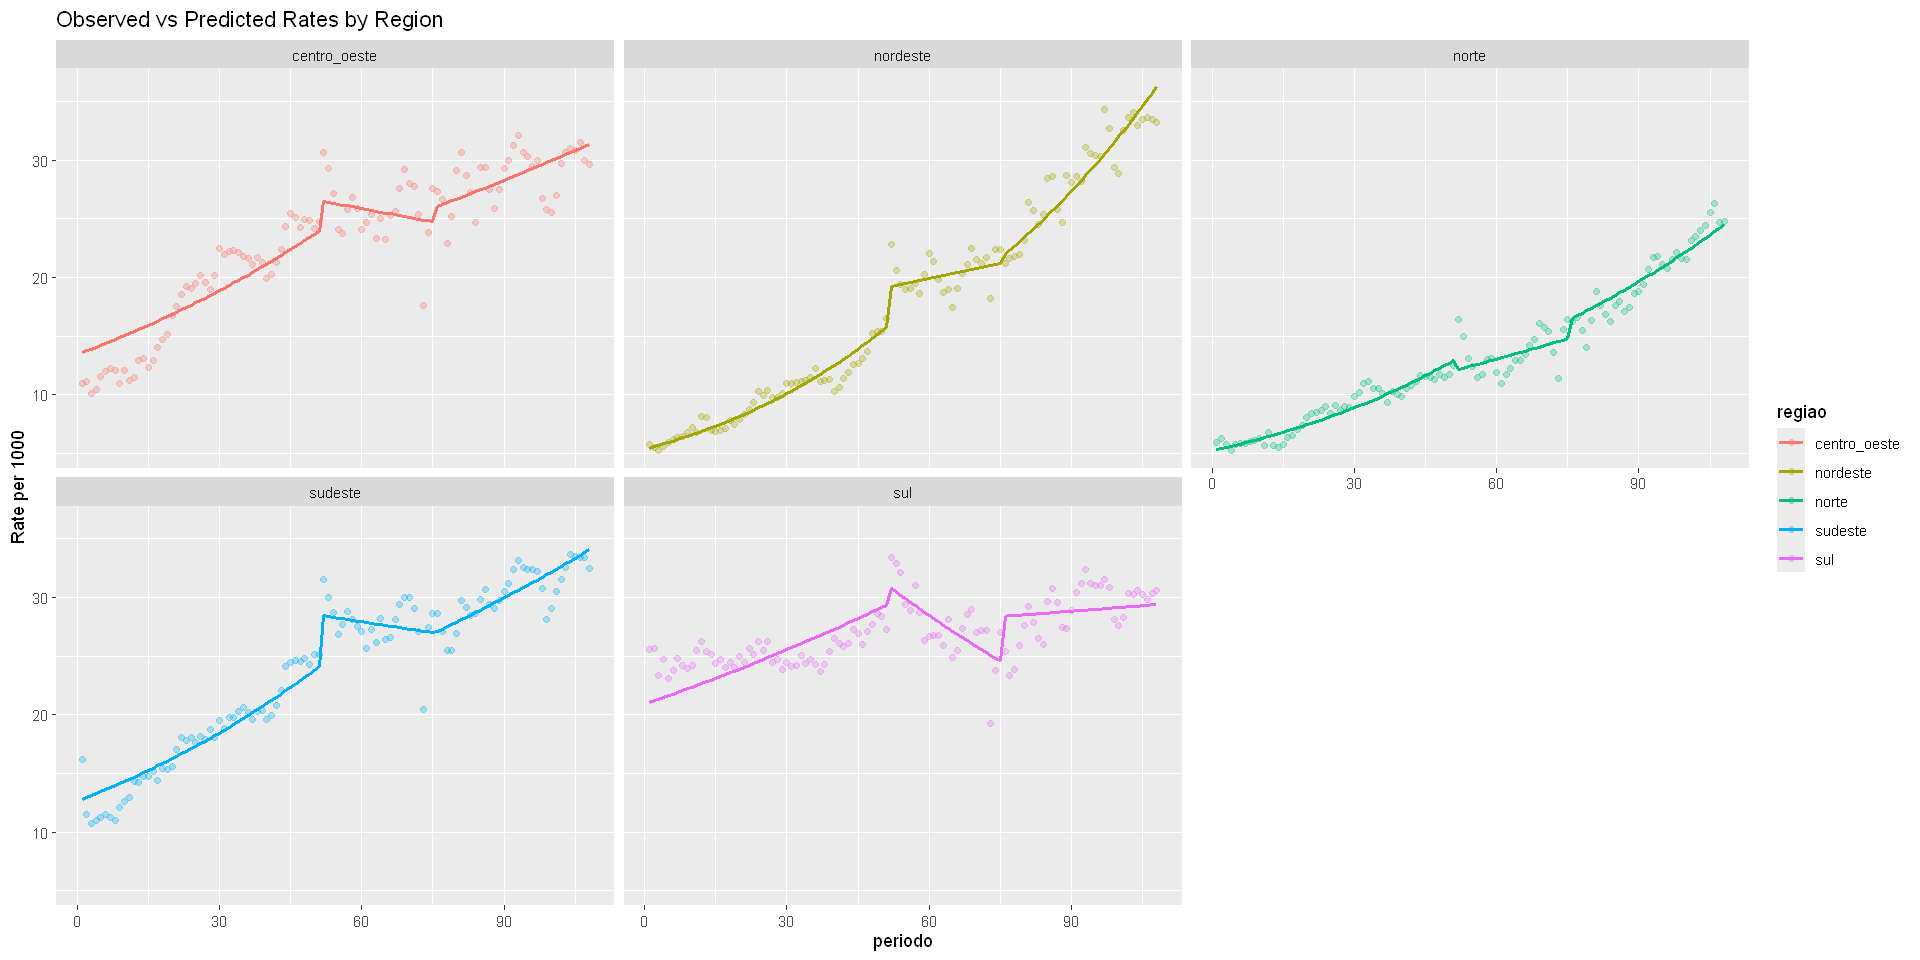

In [185]:
# Alternative plot with observed vs predicted
options(repr.plot.width = 16, repr.plot.height = 8) # Para Jupyter Notebook/RMarkdown
regression_df$pred <- predict(model, type = "response")

ggplot(regression_df, aes(periodo, mental_health_visits / (total_visits / 1000), color = regiao)) +
  geom_point(alpha = 0.3) +
  geom_line(aes(y = pred / (total_visits / 1000)), size = 1) +
  facet_wrap(~regiao) +
  labs(
    title = "Observed vs Predicted Rates by Region",
    y = "Rate per 1000"
  )


In [186]:
fixef(model)$cond[c(
    "Pandemia_Step", "Pandemia_Trend",
    "PosPandemia_Step", "PosPandemia_Trend"
)]


ERROR: Error in fixef(model)$cond: $ operator is invalid for atomic vectors
